# Apresentação:

O objetivo desse código é estudar sobre o mecanismo de atenção. Além de explicar sobre o mecânismo tradicional, o livro também abordará o uma versão causal do mecânismo de atenção.

**Este capítulo abrange:**
- As razões para o uso de **mecanismos de atenção** em redes neurais.

- Um framework básico de busca de autoatenção (_self-attention_), progredindo para um mecanismo de autoatenção aprimorado.

- Um módulo de **atenção causal** que permite que Grandes Modelos de Linguagem (LLMs) gerem um token por vez.

- O uso de _dropout_ para mascarar pesos de atenção selecionados aleatoriamente, visando reduzir o sobreajuste (_overfitting_).

- O empilhamento de múltiplos módulos de **atenção causal** em um módulo de atenção de múltiplas cabeças (_multi-head attention_).

In [1]:
import sys
import os
from pathlib import Path

# Encontra o diretório raiz do projeto (onde está a pasta 'utils')
notebook_dir = Path.cwd()
root_dir = notebook_dir.parent.parent  # Sobe dois níveis

# Adiciona ao sys.path
if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))

In [2]:
from utils.utilities import get_image

# O problema com a modelagem de sequências longas 

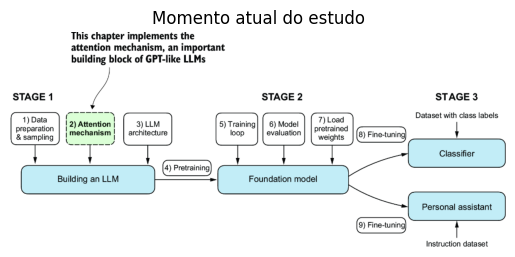

In [3]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-1.png",
    title="Momento atual do estudo"
)

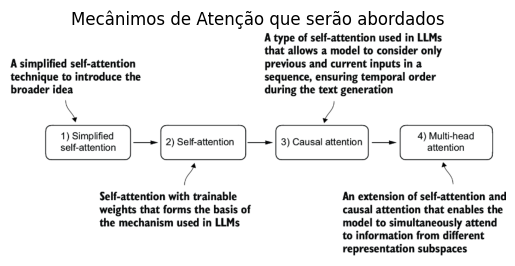

In [4]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-2.png",
    title="Mecânimos de Atenção que serão abordados"
)

# O problema com a modelagem de sequências longas

Já vimos que a arquitetura [Transformer](https://arxiv.org/abs/1706.03762) nasce como um modelo de tradução. Traduzir texto entre línguas não pode ser feito palavra por palavra, porque cada idioma tem sua própria estrutura gramatical e depende fortemente de contexto.

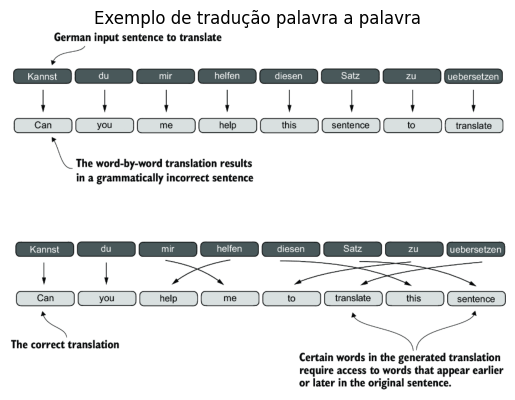

In [5]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-3.png",
    title="Exemplo de tradução palavra a palavra"
)

Para lidar com isso, modelos clássicos de tradução automática usavam uma arquitetura _encoder–decoder_:

- O **_encoder_** lê toda a frase de entrada e a transforma em uma representação vetorial compacta;
- O **_decoder_** usa essa representação para gerar a frase traduzida, token por token. Antes dos transformers, os RNNs eram amplamente usados nesse papel por conseguirem processar dados sequenciais.

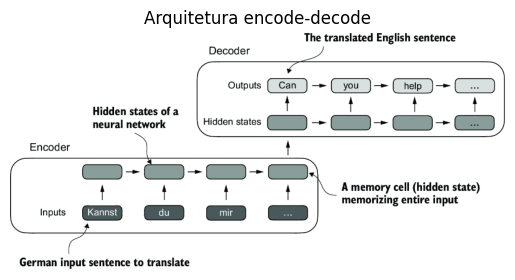

In [6]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-4.png",
    title="Arquitetura encode-decode"
)

Antes dos transformers, os **RNNs (_Recurrent Neural Networks_)** eram amplamente usados nesse papel por conseguirem processar dados sequenciais. A grande limitação das **RNNs** do tipo _encoder-decoder_ (encoder-decoder) é que a **RNN** não consegue acessar diretamente **estados ocultos (_hidden states_)** anteriores do _encoder_ durante a fase de _decoder_. 

Consequentemente, ela depende exclusivamente do estado oculto atual, que encapsula toda a informação relevante. Isso pode levar a uma perda de contexto, especialmente em frases complexas onde as dependências podem abranger longas distâncias.

Essa limitação estrutural foi o principal fator que motivou o surgimento dos **mecanismos de atenção (_attention mechanisms_)**, que permitem ao modelo focar dinamicamente em diferentes partes da entrada ao longo da geração da saída.

**Nota:**

Existem vários tipos de atenção, o livro mensiona o **Bahdanau attention**, um mecânismo de atenção criado para **RNNs**, mas existem outros. Listei alguns que encontrei na minha pesquisa própria.

- [Bahdanau Attention](https://arxiv.org/abs/1409.0473);
- [Luong Attention](https://arxiv.org/abs/1508.04025);
- [Self Attention (Artigo original do Transformer)](https://arxiv.org/abs/1706.03762);

Também vou deixar aqui um artigo interessante da **IBM** falando sobre o assunto.

- [IBM - attention-mechanism](https://www.ibm.com/br-pt/think/topics/attention-mechanism)

### O "_self_" em _Self-attention_

Na auto-atenção, o termo "auto" (_self_) refere-se à capacidade do mecanismo de **calcular pesos de atenção** relacionando diferentes posições dentro de uma única sequência de entrada. Ele avalia e aprende as relações e dependências entre várias partes da própria entrada, como palavras em uma frase ou pixels em uma imagem.

Isso contrasta com os mecanismos de atenção tradicionais, onde o foco está nas relações entre elementos de duas sequências diferentes. Um exemplo disso são os modelos de **sequência para sequência** (_seq2seq_), onde a atenção pode ocorrer entre uma sequência de entrada e uma sequência de saída.

Como o _self-attention_ pode parecer complexa, especialmente se você estiver tendo contato com ela pela primeira vez, começaremos examinando uma versão simplificada. Em seguida, implementaremos o mecanismo de auto-atenção com pesos treináveis utilizado em LLMs.

In [11]:
import torch

# Mecanismo de Atenção sem pesos
https://aclanthology.org/2020.findings-emnlp.49.pdf

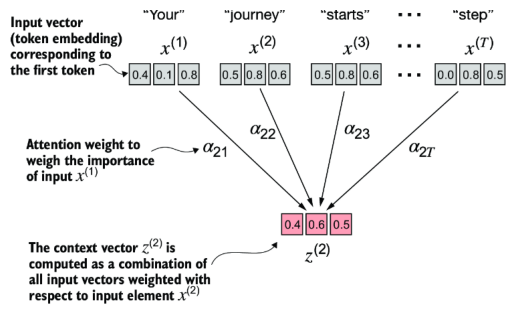

In [25]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-7.png"
)

In [12]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

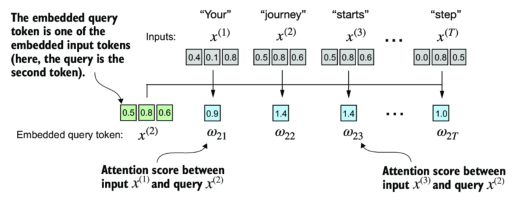

In [26]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-8.png"
)

In [13]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


### Entendendo o **Produto Escalar (_dot Product_)**

In [14]:
res = 0.

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


In [15]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


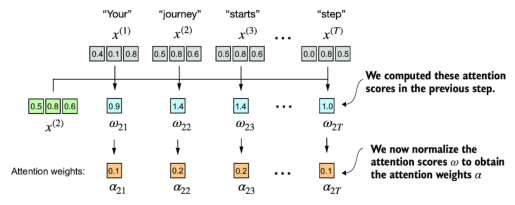

In [27]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-9.png"
)

In [16]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [17]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [18]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


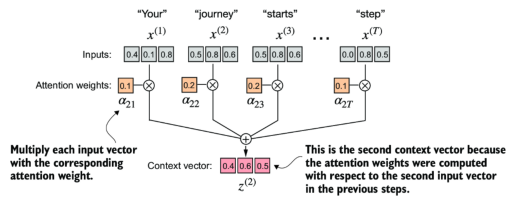

In [28]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-10.png"
)

In [19]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


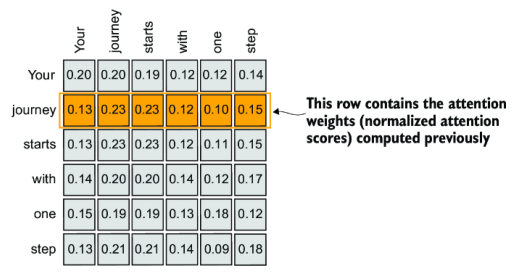

In [29]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-11.png"
)

In [20]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


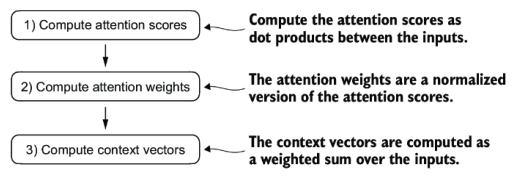

In [30]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-12.png"
)

In [ ]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [22]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [23]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [24]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


# Implementando o mecânismo de auto-atenção (_Self-Attention_)

Aqui vamos implementar o mecânismo de _self-attention_ explicitado no artigo **original de apresentação da arquitetura Transformers** ([_Attention is all you need_](https://arxiv.org/abs/1706.03762)). Esse mecanismo de auto-atenção também é chamado de **"atenção de produto escalar escalonado" (_scaled dot-product attention_)**.




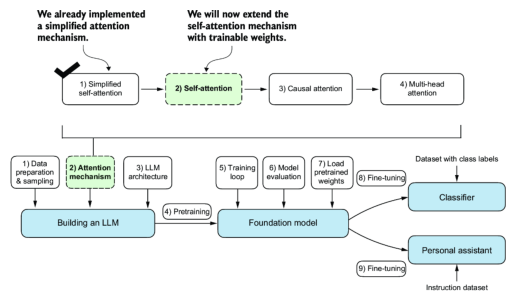

In [8]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-13.png",
)



Implementaremos o mecanismo de auto-atenção passo a passo, introduzindo as três matrizes de pesos treináveis: $W_q$, $W_k$ e $W_v$. Essas três matrizes, **operadores lineares aprendíveis**, são usadas para projetar os tokens de entrada incorporados (embeddings), $x^{(i)}$, em vetores de **consulta (_query_)**, **chave (_key_)** e **valor (_value_)**. Esse vocabulário é emprestado do **domínio de recuperação de informação e bancos de dados**, onde conceitos semelhantes são usados para armazenar, pesquisar e recuperar informações. Assim temos:

- $W_q \in \mathbb{R}^{d \times d_k}$ (Matriz de Pesos de Consulta)

    - **Função:** É o **filtro de busca**.
    - **Explicação Técnica:** Esta matriz é treinada para identificar quais dimensões do embedding  sinalizam uma "necessidade" de informação. Ela mapeia o vetor original para um espaço onde as coordenadas resultantes ($q$) representam perguntas sintáticas ou semânticas (ex: "quem é o sujeito?", "qual é o tempo verbal?").
    - **O "Puro":** É um conjunto de **hiperplanos de decisão** que extraem o perfil de busca do token.
    - **Analogia com SGBD:** É análoga a uma consulta de pesquisa em um banco de dados. Ela representa o item atual (ex: uma palavra ou token em uma frase) no qual o modelo se foca ou tenta compreender. A consulta é usada para "sondar" as outras partes da sequência de entrada para determinar quanta atenção deve ser dada a elas.

- $W_k \in \mathbb{R}^{d \times d_k}$ (Matriz de Pesos de Chave)

    - **Função:** É o **filtro de indexação**.
    - **Explicação Técnica:**  projeta  em um espaço de compatibilidade com . Ela aprende a destacar    características do token que servem como "respostas" para as consultas. Se  procura por um "verbo no passado", será treinada para gerar vetores com alta magnitude em direções que sinalizam "verbo no passado".
    - **O "Puro":** Define a **chave de acesso** que torna o token visível e relevante para as consultas de outros tokens.
    - **Analogia com SGBD:** É análoga a uma consulta de pesquisa em um banco de dados. Ela representa o item atual (ex: uma palavra ou token em uma frase) no qual o modelo se foca ou tenta compreender. A consulta é usada para "sondar" as outras partes da sequência de entrada para determinar quanta atenção deve ser dada a elas.

- $W_v \in \mathbb{R}^{d \times d_v}$ (Matriz de Pesos de Valor)

    - **Função:** É o **filtro de conteúdo/mensagem**.
    - **Explicação Técnica:** Enquanto  e  cuidam da interatividade (quem olha para quem),  cuida da substância. Ela extrai do embedding  apenas a informação que é útil passar para a próxima camada do Transformer. Ela pode, por exemplo, aprender a ignorar ruídos gramaticais e focar apenas no conceito semântico central da palavra.
    - **O "Puro":** É o **codificador de herança**, transformando o input bruto em uma representação refinada que será transportada para o próximo nível da rede.
    - **Analogia com SGBD:** Neste contexto, é semelhante ao valor em um par chave-valor de um banco de dados. Ele representa o conteúdo real ou a representação dos itens de entrada. Assim que o modelo determina quais chaves (e, portanto, quais partes da entrada) são mais relevantes para a consulta (o item de foco atual), ele recupera os valores correspondentes.
    

---
As matrizes  são **parâmetros de estado** do modelo.

1. **Independência Funcional:** O fato de serem três matrizes distintas permite que o modelo aprenda que uma palavra pode ser "muito importante para ser observada" ( forte via ) sem necessariamente estar "procurando muita informação" ( fraco via ).
2. **Mapeamento de Baixo Posto (Low-rank):** Frequentemente , o que força as matrizes  a realizarem uma **compressão informativa**, retendo apenas as características (features) mais úteis para a tarefa de linguagem, eliminando a redundância do embedding original.

**Em suma:**  são os **moldes** que dão forma ao fluxo de dados. O treinamento do modelo consiste em ajustar cada valor dentro dessas matrizes para que a interação final entre os tokens produza a melhor predição possível.

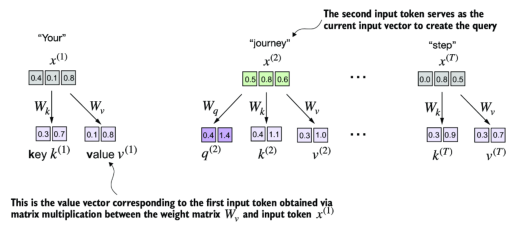

In [10]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-14.png",
)

Tudo começa com o embedding de entrada $x \in \mathbb{R}^d$. Para que o modelo não seja uma "régua fixa", aplicamos três matrizes de pesos aprendíveis $W_q, W_k, W_v \in \mathbb{R}^{d \times d_k}$.

Matematicamente, realizamos uma Extração de Características (Feature Extraction) via mapeamento linear:

- $q^{(i)} = x^{(i)} W_q$ (Query: O que o token busca)
- $k^{(i)} = x^{(i)} W_k$ (Key: Como o token é indexado)
- $v^{(i)} = x^{(i)} W_v$ (Value: A informação que o token carrega)

O Rigor: Não é apenas uma mudança de base (pois $W$ não precisa ser quadrada ou invertível), mas uma projeção para subespaços funcionais onde o ruído de $x$ é filtrado para focar na tarefa específica (procurar, ser encontrado ou informar).

In [ ]:
x_2 = inputs[1] # segundo elemento de entrada
d_in = inputs.shape[1] # o tamanho da embedding de entrada, d=3
d_out = 2 # o tamanho da embedding de saída, d=2

In [32]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [ ]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [34]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


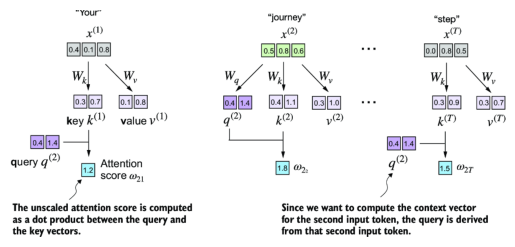

In [35]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-15.png"
)

In [ ]:
keys_2 = keys[1] # Python é indexado no zero
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22) # O resultado para a pontuação de atenção não normalizada

tensor(1.8524)


In [37]:
attn_scores_2 = query_2 @ keys.T # Todas as pontuações de atenção para a consulta fornecida.
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


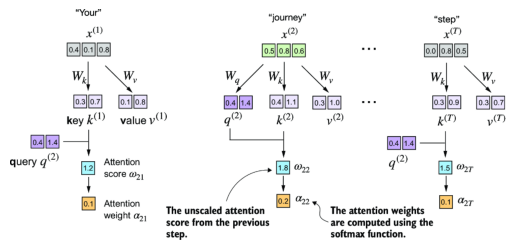

In [38]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-16.png"
)

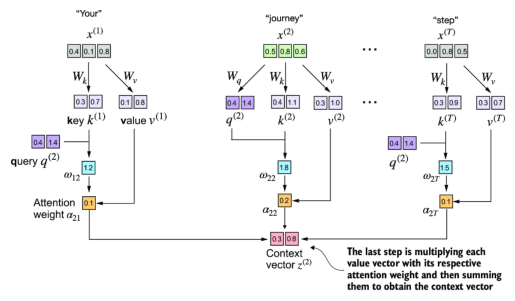

In [41]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-17.png"
    )

In [42]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3069, 0.8188])


###  A lógica por trás da atenção de produto escalar escalonado (_scaled-dot product attention_)

A razão para a normalização pelo tamanho da dimensão do _embedding_ é melhorar o desempenho do treinamento, evitando **gradientes pequenos** ([_Vanishing Gradient Problem_](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)). Por exemplo, ao aumentar a dimensão do _embedding_ — que geralmente é superior a 1.000 em LLMs do tipo GPT — produtos escalares elevados podem resultar em gradientes muito pequenos durante a retropropagação (_backpropagation_), devido à função softmax aplicada a eles.

À medida que os produtos escalares aumentam, a **função softmax** se comporta mais como uma função degrau (_step function_), resultando em gradientes próximos de zero. Esses gradientes pequenos podem retardar drasticamente o aprendizado ou fazer com que o treinamento estagne.

O escalonamento pela raiz quadrada da dimensão do _embedding_ é a razão pela qual este mecanismo de auto-atenção _self-attention_ também é chamado de atenção de produto escalar escalonado (_scaled-dot product attention_).

## Implementando o _self-attention_

Dado toda a explicação, agora vamos realmente implementar o mecânismo de _self-attention_. Faremos isso utilizando o **paradigma [PPO](https://pt.wikipedia.org/wiki/Programa%C3%A7%C3%A3o_orientada_a_objetos)** por meio da **estrutura de Classes do Python**.

In [43]:
import torch.nn as nn

In [ ]:
# Implementando o self-attention
class SelfAttention_v1(nn.Module):
    def __init__ (self, d_in, d_out):
        super().__init__()
        # Inicio aleatório dos pesos
        self.Wq = nn.Parameter(torch.rand(d_in, d_out)) # Query weight matrix
        self.Wk = nn.Parameter(torch.rand(d_in, d_out)) # Key weight matrix
        self.Wv = nn.Parameter(torch.rand(d_in, d_out)) # Value weight matrix

    def forward(self, x):
        # Projeções lineares
        """
        Aqui a ideia é gerar o Feacture Extraction por meio das
        matrizes de pesos Wq, Wk e Wv. Matemáticamente falando,
        esse processo gera um sub-espaço linear para as
        """
        keys = x @ self.Wk
        values = x @ self.Wv
        queries = x @ self.Wq

        attn_scores = queries @ keys.T # eij = dot-product
        attn_weights = torch.softmax(
            attn_scores / keys.shape[1]**0.5, # Escalonamento
            dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [46]:
torch.manual_seed(123)
self_attn = SelfAttention_v1(d_in, d_out)
sa_v1 = self_attn(inputs)
print(sa_v1)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


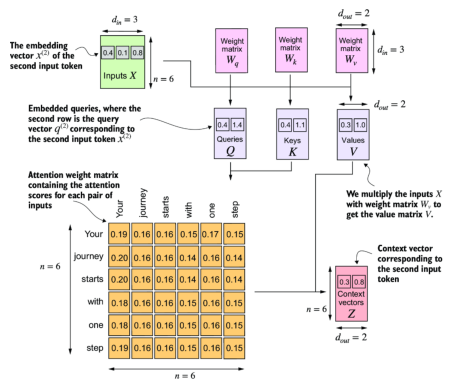

In [47]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-18.png"
)

## Versão treinável

A auto-atenção envolve as matrizes de pesos treináveis $W_q$, $W_k$ e $W_v$. Essas matrizes transformam os dados de entrada em consultas, chaves e valores, respectivamente, que são componentes cruciais do mecanismo de atenção. À medida que o modelo é exposto a mais dados durante o treinamento, ele ajusta esses pesos treináveis.

Podemos melhorar a implementação `SelfAttention_v1` utilizando as camadas `nn.Linear` do **PyTorch**, que realizam a multiplicação de matrizes de forma eficaz quando as unidades de **viés (bias)** estão desativadas. Além disso, uma vantagem significativa de usar `nn.Linear` em vez de implementar manualmente via `nn.Parameter(torch.rand(...))` é que a `nn.Linear` possui um **esquema de inicialização de pesos otimizado**, contribuindo para um treinamento de modelo mais estável e eficaz.

In [51]:
# Segunda versão do Self-Attention
class SelfAttention_v2(nn.Module):
    def __init__(self,d_in, d_out, qkv_bias=False):
        super().__init__()
        self.Wq = nn.Linear(d_in, d_out, bias=qkv_bias) # Query weight matrix with bias
        self.Wk = nn.Linear(d_in, d_out, bias=qkv_bias) # Key weight matrix with bias
        self.Wv = nn.Linear(d_in, d_out, bias=qkv_bias) # Value weight matrix with bias

    def forward(self, x):

        # Projeções lineares
        keys = self.Wk(x)
        values = self.Wv(x)
        queries = self.Wq(x)

        attn_scores = queries @ keys.T # eij = dot-product
        attn_weights = torch.softmax(
            attn_scores / keys.shape[1]**0.5,  # Escalonamento
            dim=-1
        )

        context_vec_2 = attn_weights @ values
        return context_vec_2

In [52]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


# Escondendo palavras futuras com causal attention

Para muitas tarefas de **LLM**, você desejará que o mecanismo de _self-attention_ considere apenas os tokens que aparecem antes da posição atual ao prever o próximo token em uma sequência. A **Atenção Causal (_Causal Attention_)**, também conhecida como **Atenção Mascarada (_masked attention_)**, é uma forma especializada de _self-attetion_. Ela restringe o modelo para que considere apenas as entradas anteriores e atuais de uma sequência ao processar qualquer token específico durante o **cálculo dos scores de atenção**. Isso contrasta com o mecanismo de _self-attention_ padrão, que permite o acesso a toda a sequência de entrada de uma vez.

Agora, modificaremos o mecanismo de _self-attention_ padrão para criar um mecanismo de _causal attention_, o que é essencial para desenvolver um LLM nos capítulos seguintes. Para alcançar isso em **LLMs** do tipo **GPT**, para cada token processado, nós mascaramos os tokens futuros — aqueles que vêm depois do token atual no texto de entrada. Nós mascaramos os pesos de atenção acima da diagonal e normalizamos os pesos de atenção não mascarados de modo que a soma dos pesos de atenção em cada linha **seja igual a 1**. Posteriormente, implementaremos este **procedimento de mascaramento** e **normalização** em código.

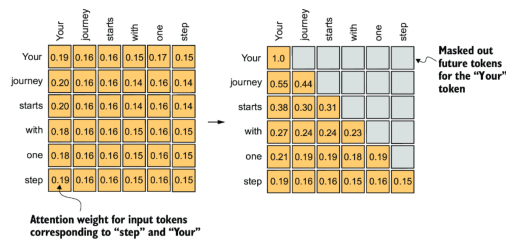

In [54]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-19.png"
)

## Implementando a Máscara de _causal attention_

Nosso próximo passo é implementar a **máscara de atenção causal** em código. Para aplicar os passos necessários e obter os **pesos de atenção mascarados**, vamos trabalhar com os **_scores_** e **pesos de atenção** da seção anterior para programar o mecanismo de _Causal Attention_.

Uma maneira de obter a **matriz de pesos de atenção mascarada na atenção causal** é aplicar a **função softmax aos _scores_ de atenção**, zerando os elementos acima da diagonal e normalizando a matriz resultante.

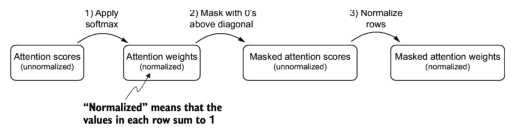

In [55]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-20.png"
)

In [56]:
# Reusando SelfAttention_v2 (Por conveniência)
queires = sa_v2.Wq(inputs) 
keys = sa_v2.Wk(inputs)
values = sa_v2.Wv(inputs)

attn_scores = queires @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


A maneira mais simples de mascarar os pesos de atenção futuros é criando uma máscara através da função `tril` (de _triangular lower_) do **PyTorch**, com os elementos abaixo da diagonal principal (incluindo a própria diagonal) definidos como 1 e acima da diagonal principal definidos como 0:

In [58]:
# Gerando matrix de mascaramento (lower triangular)
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Em seguida, podemos multiplicar os pesos de atenção por essa máscara para zerar as pontuações de atenção acima da diagonal

In [59]:
# Aplicando a máscara
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- No entanto, se a máscara fosse aplicada **após** o softmax, como feito acima, ela interromperia a distribuição de probabilidade criada pelo softmax.

- O softmax garante que todos os valores de saída somem 1. Mascarar após o softmax exigiria uma renormalização das saídas para que somassem 1 novamente, o que complica o processo e pode levar a efeitos indesejados.

- Para garantir que as linhas somem 1, podemos normalizar os pesos de atenção da seguinte forma:

In [61]:
# Normalizando as linhas após a aplicação da máscara
row_sums = masked_simple.sum(dim=-1, keepdim=True) # Lembrando que masked_simple é um torch.Tensor
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


### Vazamento de Informações (_Information leakage_)

Quando aplicamos uma máscara e depois renormalizamos os pesos de atenção, pode parecer inicialmente que as informações dos tokens futuros (que pretendemos mascarar) ainda poderiam influenciar o token atual, porque seus valores fazem parte do cálculo do softmax. No entanto, a percepção fundamental é que, ao renormalizarmos os pesos de atenção após o mascaramento, o que estamos fazendo essencialmente é recalcular o **softmax** sobre um subconjunto menor (já que as posições mascaradas não contribuem para o valor do **softmax**).

A elegância matemática do **softmax** é que, apesar de inicialmente incluir todas as posições no denominador, após o mascaramento e a renormalização, o efeito das posições mascaradas é anulado — elas não contribuem para o **_score_ do softmax** de nenhuma forma significativa.

Em termos simples, após o **mascaramento** e a **renormalização**, **a distribuição dos pesos de atenção é como se tivesse sido calculada apenas entre as posições não mascaradas desde o início**. Isso garante que não haja **vazamento de informações** de tokens futuros (ou de outra forma mascarados), conforme pretendido.

Embora pudéssemos encerrar nossa implementação da atenção causal neste ponto, ainda podemos melhorá-la. Vamos aproveitar uma propriedade matemática da função **softmax** e implementar o cálculo dos pesos de atenção mascarados de forma mais eficiente em menos etapas.

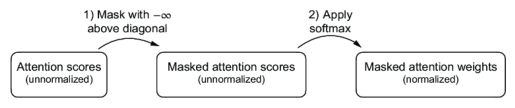

In [62]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-21.png"
)

### Softmax

A **Softmax** é a generalização da **Sigmoide** para um vetor de $K$ classes. Ela pertence à **Família Exponencial**, onde as interações lineares são convertidas em medidas de massa de probabilidade. Dado um vetor de entrada $\mathbf{z}$ (logits), a probabilidade da classe $i$ é:

$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

        O livro não menciona essa parte, mas eu particularmente gosto desse approach mais teórico para entender melhor as coisas. Meu objetivo aqui é entender a softmax para além de "função ativação", mas sim como componente dos Modelo Linear Generalizado (GLM) para dar um background formal.

#### 1. A Raiz: Família Exponencial

A **Softmax** e a **Sigmoide** não são arbitrárias; elas derivam da **Família Exponencial** de distribuições (que inclui a Gaussiana, Bernoulli e Multinomial). Uma distribuição pertence a esta família se sua função de densidade pode ser escrita como:

$$f(y; \eta) = h(y) \exp\left( \eta^T T(y) - A(\eta) \right)$$

Onde:

* $\eta$ é o **parâmetro natural** (o **logit**/_score_ bruto).
* $T(y)$ é a estatística suficiente.
* $A(\eta)$ é a **função de partição logarítmica**, crucial para a normalização.

#### 2. Função de Ligação (_Link Function_)

Em _deep learning_ existem as **funções de ativação (_activation function_)**. Em modelos estatísticos, quando queremos predizer valores no $discreto$, podemos relacionar preditores lineares $\mathbf{w}^T \mathbf{x}$ (que predizem no $contínuo$) ao valor esperado da resposta $\mu = E[Y]$, que ajusta a capacidade do modelo a inferir em domínios além do $contínuo$. A função que possibilita essa ponte é denominada **Função de Ligação (link function)**  é o que faz essa ponte:

$$g(\mu) = \eta = \mathbf{w}^T \mathbf{x}$$

Para a distribuição de **Bernoulli**, $K=2$, onde $K$ são é a **cardinalidade do conjunto de classes a serem preditas** (eg. 0 ou 1), a função de ligação natural é o **Logit**:

$$\eta = \ln\left( \frac{\mu}{1 - \mu} \right)$$

A inversa desta ligação (a *mean function*) é a **Sigmoide**:

$$\mu = \sigma(\eta) = \frac{1}{1 + e^{-\eta}}$$

        É daí que vem o nome da regressão logística e por isso que ela é um modelo de classificação, apesar de ter regressão no nome. Inclusive, uma regressão logistica é uma rede neural com apenas uma camada (ignorando a camada de entrada).

#### 3. Softmax: A Generalização multiclasses da sigmoid

Quando passamos da Bernoulli para a distribuição **Multinomial**, $K>2$ (várias categorias, como tokens em um vocabulário), passsamos a ter um **multinomial logit**, definido como:

$$\eta = log\frac{p_i}{p_K}, \ \ i = 1, \dots, K-1$$

onde, $$p_i=\frac{e^{\eta_i}}{1 + \sum_{j=1}^{K-1} e^{\eta_j}},\qquad i = 1, \dots, K-1,$$

$$p_K=\frac{1}{1 + \sum_{j=1}^{K-1} e^{\eta_j}}.$$



De modo que a generalização da Sigmoide resulta na **Softmax**. Se temos um vetor de parâmetros naturais (logits)  $\mathbf{z} = [z_1, z_2, \dots, z_k]$, a **Softmax** mapeia cada $z_i$ para uma probabilidade:

$$\text{Softmax}(z_i) = p_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \ \ i = 1,\dots,K$$

com,

$$\sum_{i=1}^K p_i = 1, \ \ p_i \in (0,1)$$


Essa não é a única forma de se chegar na **Softmax**, poderiamos pensar no **Log-Sum-Exp (LSE)**, mas já foge do escopo da explicação que gostaria de trazer.

#### 4. O ponto que faz a Softmax ser interessante

A softmax **converte suas entradas em uma distribuição de probabilidade**. Quando valores de infinito negativo ($-\infty$) estão presentes em uma linha, a função softmax os trata como probabilidade zero. (Matematicamente, isso ocorre porque $e^{-\infty}$ se aproxima de 0).

Podemos implementar esse "truque" de mascaramento mais eficiente criando uma máscara com 1s acima da diagonal e, em seguida, substituindo esses 1s por valores de infinito negativo (`-inf`):

In [65]:
# Aplicando a máscara com -inf
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [66]:
# Cálculo dos pesos de atenção com a máscara aplicada
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### Mascarando pesos de atenção adicionais com _dropout_

O **_Dropout_** em _deep learning_ é uma técnica na qual unidades de camadas ocultas, selecionadas **aleatoriamente**, são ignoradas durante o treinamento, efetivamente "descartando-as" (_dropping them out_). Este método ajuda a evitar o _overfitting_, garantindo que o modelo não se torne excessivamente dependente de qualquer conjunto específico de unidades da camada oculta. É importante enfatizar que o _dropout_ é usado **apenas durante o treinamento**. Não se faz inferência com _dropout_ ativado, é jogar capacidade fora atoa.

Na **arquitetura Transformer**, incluindo modelos como o GPT, o _dropout_ no mecanismo de atenção é tipicamente aplicado em dois momentos específicos: 

- após o cálculo dos pesos de atenção; ou 
- após a aplicação dos pesos de atenção aos vetores de valor (values). 

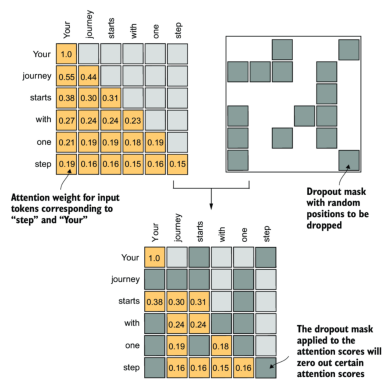

In [67]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/3-22.png"
)

In [68]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)    # dropout layer with 50% dropout rate
example = torch.ones(6, 6)      # matrix of ones (6 x 6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


Ao aplicar _dropout_ a uma matriz de pesos de atenção com uma taxa de $50\%$, metade dos elementos na matriz são definidos aleatoriamente como zero. Para compensar a redução nos elementos ativos, os valores dos elementos restantes na matriz são escalonados (aumentados) por um fator de $1/0,5 = 2$. Esse escalonamento é crucial para **manter o equilíbrio geral dos pesos de atenção**, garantindo que a influência média do mecanismo de atenção permaneça consistente tanto durante a fase de treinamento quanto na fase de inferência.

In [69]:
torch.manual_seed(123)
# Applying dropout to attention weights
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


        O livro menciona que esses valores podem ser diferente, dado o Sistema Operacional. Não vou aprofundar nesse ponto, para mais informações, https://github.com/pytorch/pytorch/issues/121595.

Agora, estamos prontos para realizar uma implementação funcional da autotenção (_self-attention_), incluindo as máscaras causal e de dropout.

Mais um detalhe é implementar o código para lidar com lotes (_batches_) que consistem em mais de uma entrada, de modo que nossa classe `CausalAttention` suporte as saídas em lote produzidas pelo carregador de dados (_data loader_) que implementamos no capítulo 2.

Para simplificar, a fim de simular tal entrada em lote, duplicamos o exemplo de texto de entrada:

In [70]:
# Criando um batch de inputs
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 entradas com 6 tokens cada, e cada token tem dimensão de incorporação 3.

torch.Size([2, 6, 3])


In [ ]:
# Classe do Causal Attention
 